# Movie Recommender System

## Overview

## Objectives

## Summary

### Importing Libraries

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### The Datasets

In [214]:
ratings = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\ratings.csv', sep =",")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [215]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [216]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [217]:
movies = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\movies.csv', sep =",")
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [218]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [219]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [220]:
# Removing the time stamp
ratings = ratings.drop(["timestamp"], axis = 1)

In [221]:
# Merge the datasets on movie id
movie_ratings = movies.merge(ratings, on ="movieId")
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [222]:
# Adding columns : average rating and number of ratings per movie
movie_av_ratings = movie_ratings.groupby("title")["rating"].mean().reset_index()
movie_av_ratings = movie_av_ratings.rename(columns={"rating":"average rating"})
movie_av_ratings.head()

,title,average rating
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",3.000000
1,"""Great Performances"" Cats (1998)",2.896648
2,#1 Cheerleader Camp (2010),2.111111
3,#Captured (2017),3.750000
4,#Female Pleasure (2018),3.666667


In [223]:
movie_count_ratings = movie_ratings.groupby("title")["rating"].count().reset_index()
movie_count_ratings = movie_count_ratings.rename(columns={"rating": "rating count"})
movie_count_ratings.head()

,title,rating count
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",1
1,"""Great Performances"" Cats (1998)",179
2,#1 Cheerleader Camp (2010),9
3,#Captured (2017),2
4,#Female Pleasure (2018),3


In [224]:
# Merging the two sets
dataset = movie_count_ratings.merge(movie_av_ratings, on = "title")
dataset.head()

,title,rating count,average rating
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",1,3.000000
1,"""Great Performances"" Cats (1998)",179,2.896648
2,#1 Cheerleader Camp (2010),9,2.111111
3,#Captured (2017),2,3.750000
4,#Female Pleasure (2018),3,3.666667


### Some DataViz and pre-processing

array([[<AxesSubplot:title={'center':'rating count'}>,
        <AxesSubplot:title={'center':'average rating'}>]], dtype=object)

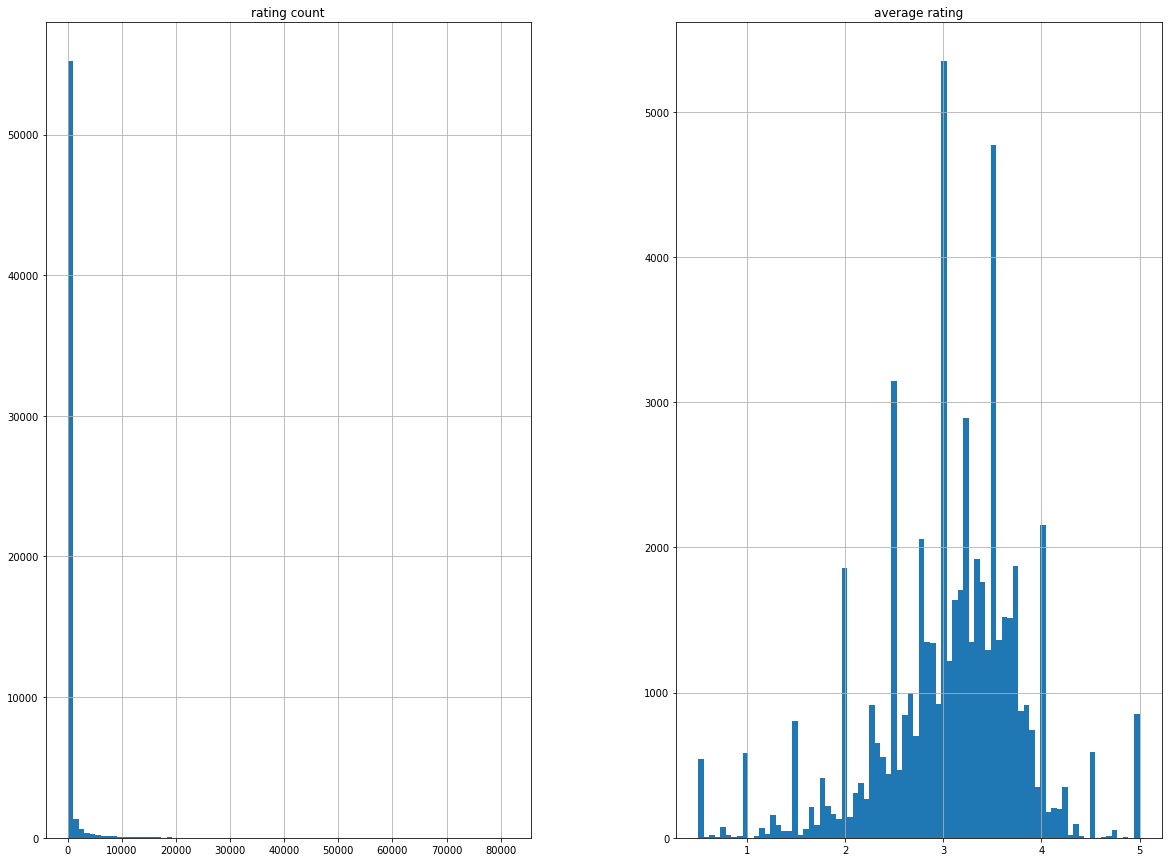

In [225]:
dataset.hist(bins = 80, figsize=(20 , 15) )

The hist plot suggests the existance of some outliers seen as so many movies have been rated very few times, we need to set a threshold of popularity to only take into consideration movies that have been seen and rated by many people. I decided to set the threshold at 30 meaning that if less than 30 people have rated the movie, it won't be considered by the recommender.

In [226]:
popularity = 30
dataset = dataset[dataset["rating count"]>= popularity]
dataset.describe()

,rating count,average rating
count,15912.000000,15912.000000
mean,1555.458333,3.256978
std,4586.022847,0.480636
min,30.000000,0.854839
25%,66.000000,2.972858
50%,201.000000,3.319956
75%,909.250000,3.611803
max,81491.000000,4.483096


Now we see that the minimun value for rating count is 30, mean 50 and so on.

## Popularity filtering

Popularity filtering is based on the idea that movies that have been rated highly by a lot of people are likely to please the new person. To do this, we need to use a weighted average that enable to gauge the popularity depending on how many people rated the movie; meaning that for example a movie that has been rated 4 stars by say 100 people should be recommended more than a movie that has been rated 5 stars by only 2 people.

The formula for the weighed average is as follows:

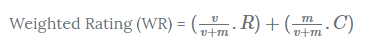
where:
- v is the number of votes for a movie, 
- m is the min votes required to be in the chart
- R is the average rating of the movie 
- C is the mean vote across the entire dataset

In [227]:
# Let's calculate C which is the average rating of all movies
C = dataset["average rating"].mean()
C

3.2569781620132923

In [228]:
# Now we need to set the value of m which is the minimum number of votes that a movie has to have to figure in the chart
# I used the 75% percentile i.e for a movie to feature in the chart it must have more votes than at least 75% of the movies
m = dataset["rating count"].quantile(0.75)
m

909.25

In [229]:
# Filter out the movies that can feature in the charts
dataset = dataset[dataset["rating count"] >= m]
dataset.shape

(3978, 3)

In [230]:
# The dataset now has only 3978 movies 
# Now we need to calculate the weighed scores of each of these movies and store it a new column
def weighted_score(x, m=m, C=C):
    v = x["rating count"]
    R = x["average rating"]
    return (v/(v+m) * R) + (m/(v+m)*C)

In [231]:
dataset["weighted score"] = dataset.apply(weighted_score, axis =1)
dataset = dataset.sort_values("weighted score", ascending = False)
dataset.head(10)

,title,rating count,average rating,weighted score
41782,"Shawshank Redemption, The (1994)",81482,4.413576,4.400812
19301,"Godfather, The (1972)",52498,4.324336,4.306165
55289,"Usual Suspects, The (1995)",55366,4.284353,4.267754
19302,"Godfather: Part II, The (1974)",34188,4.261759,4.235728
40816,Schindler's List (1993),60411,4.247579,4.232891
16751,Fight Club (1999),58773,4.228311,4.213513
38620,Rear Window (1954),20162,4.237948,4.195618
34839,One Flew Over the Cuckoo's Nest (1975),36058,4.218662,4.195008
182,12 Angry Men (1957),16569,4.243014,4.191719
41448,Seven Samurai (Shichinin no samurai) (1954),13367,4.254769,4.191220


Here we have the top 10 recommended movies. This recommendation is general and does not take into consideration the watching history of the user nor their personal preferences. 

[Text(0.5, 1.0, 'Top 10 recommended movies')]

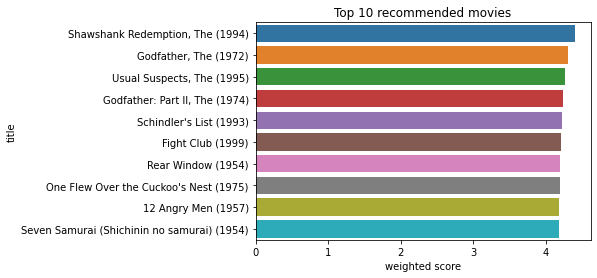

In [232]:
# Visualize the results
ds = dataset.head(10)
sns.barplot(x = "weighted score", y = "title", data = ds).set(title = "Top 10 recommended movies")

## Content based filtering

suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

For this project I'll be using both the genre of the movie and its tag

In [233]:
# Import the tags dataset
tags = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\tags.csv', sep =",")
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [234]:
# Merging it with the movies dataset which contains the genres
movie_desc = tags.merge(movies, on = "movieId" )
movie_desc = movie_desc.drop("timestamp", axis =1)
movie_desc.head()

,userId,movieId,tag,title,genres
0,3,260,classic,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,3,260,sci-fi,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2,110,260,action,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3,110,260,adventure,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,110,260,fantasy,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [235]:
movie_desc = movie_desc.dropna()
movie_desc.isnull().sum()

userId     0
movieId    0
tag        0
title      0
genres     0
dtype: int64

In [236]:
# Combining the genre and tag in one column
movie_desc["genres"] = movie_desc['tag'].astype(str) +" "+ movie_desc["genres"]
movie_desc = movie_desc.drop("tag", axis = 1)
movie_desc = movie_desc.rename(columns={"genres": "tag and genre"})
movie_desc.head()

,userId,movieId,title,tag and genre
0,3,260,Star Wars: Episode IV - A New Hope (1977),classic Action|Adventure|Sci-Fi
1,3,260,Star Wars: Episode IV - A New Hope (1977),sci-fi Action|Adventure|Sci-Fi
2,110,260,Star Wars: Episode IV - A New Hope (1977),action Action|Adventure|Sci-Fi
3,110,260,Star Wars: Episode IV - A New Hope (1977),adventure Action|Adventure|Sci-Fi
4,110,260,Star Wars: Episode IV - A New Hope (1977),fantasy Action|Adventure|Sci-Fi


In [238]:
# Removing unecessary characters
movie_desc["tag and genre"]  = movie_desc["tag and genre"].str.replace("|"," ")
movie_desc.head()

C:\Users\imane\AppData\Local\Temp/ipykernel_31756/1218737094.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_desc["tag and genre"]  = movie_desc["tag and genre"].str.replace("|"," ")


,userId,movieId,title,tag and genre
0,3,260,Star Wars: Episode IV - A New Hope (1977),classic Action Adventure Sci-Fi
1,3,260,Star Wars: Episode IV - A New Hope (1977),sci-fi Action Adventure Sci-Fi
2,110,260,Star Wars: Episode IV - A New Hope (1977),action Action Adventure Sci-Fi
3,110,260,Star Wars: Episode IV - A New Hope (1977),adventure Action Adventure Sci-Fi
4,110,260,Star Wars: Episode IV - A New Hope (1977),fantasy Action Adventure Sci-Fi


Next move is to transform the text contained in tag and genre to a vector matrix using victorization. I'll be using TfidfVectorizer which determines the importance of a word. It does this by computing the relative frequency of the word in the document (term instances/total instances), and the Inverse Document Frequency which is the relative count of documents containing the term (log(number of documents/documents with term)), the result of TF * IDF is the importance of the word.